In [4]:
# import all packages
from sodapy import Socrata
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
np.random.seed(42)
%matplotlib inline
import carto2gpd
import esri2gpd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import hvplot.pandas
from shapely.geometry import Point
import osm2gpd
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

# 1 Data Imports
## Major Data Set

In [5]:
client = Socrata("data.cityofchicago.org", 
                'GWonJMlcoqKVThtJkHvUXcBVo')
results = client.get(
    "fg6s-gzvg", 
    where="start_time >= '2018-01-01T00:00:00.000'",
    limit=4000000)

In [6]:
trips = pd.DataFrame.from_records(results)
trips.head()

,trip_id,start_time,stop_time,bike_id,trip_duration,from_station_id,from_station_name,to_station_id,to_station_name,user_type,gender,birth_year,from_latitude,from_longitude,from_location,to_latitude,to_longitude,to_location
0,17536702,2018-01-01T00:12:00.000,2018-01-01T00:17:00.000,3304,323,69,Damen Ave & Pierce Ave,159,Claremont Ave & Hirsch St,Subscriber,Male,1988,41.909396006,-87.677691929,"{'type': 'Point', 'coordinates': [-87.67769192...",41.907781,-87.685854,"{'type': 'Point', 'coordinates': [-87.685854, ..."
1,17536703,2018-01-01T00:41:00.000,2018-01-01T00:47:00.000,5367,377,253,Winthrop Ave & Lawrence Ave,325,Clark St & Winnemac Ave,Subscriber,Male,1984,41.968812,-87.657659,"{'type': 'Point', 'coordinates': [-87.657659, ...",41.973345,-87.667682,"{'type': 'Point', 'coordinates': [-87.667682, ..."
2,17536704,2018-01-01T00:44:00.000,2018-01-01T01:33:00.000,4599,2904,98,LaSalle St & Washington St,509,Troy St & North Ave,Subscriber,Male,1989,41.882664,-87.63253,"{'type': 'Point', 'coordinates': [-87.63253, 4...",41.909769302,-87.705280487,"{'type': 'Point', 'coordinates': [-87.70528048..."
3,17536706,2018-01-01T00:53:00.000,2018-01-01T00:56:00.000,3696,183,129,Blue Island Ave & 18th St,205,Paulina St & 18th St,Subscriber,Male,1989,41.857556,-87.661535,"{'type': 'Point', 'coordinates': [-87.661535, ...",41.857901,-87.668745,"{'type': 'Point', 'coordinates': [-87.668745, ..."
4,17536705,2018-01-01T00:53:00.000,2018-01-01T01:05:00.000,2302,747,125,Rush St & Hubbard St,364,Larrabee St & Oak St,Subscriber,Male,1983,41.890173,-87.626185,"{'type': 'Point', 'coordinates': [-87.626185, ...",41.900219493,-87.642985468,"{'type': 'Point', 'coordinates': [-87.64298546..."


In [7]:
start_trips = trips.groupby('from_station_id').size().reset_index(name='trip_counts')
start_trips.head()

,from_station_id,trip_counts
0,100,31838
1,101,1063
2,102,329
3,103,2411
4,106,13199


In [8]:
stations = gpd.read_file('https://data.cityofchicago.org/resource/bbyy-e7gq.geojson')
stations = stations[['id','total_docks','station_name','status','geometry']]
len(stations)

611

In [9]:
station_trip = (
    stations
    .merge(start_trips,left_on='id',right_on='from_station_id')
).to_crs(epsg=3857)
station_trip.head()

,id,total_docks,station_name,status,geometry,from_station_id,trip_counts
0,2,39,Buckingham Fountain,In Service,POINT (-9753874.787486579 5142499.336427348),2,9422
1,3,55,Shedd Aquarium,In Service,POINT (-9753296.74770876 5141111.239290465),3,24757
2,4,23,Burnham Harbor,In Service,POINT (-9753073.286053874 5139473.34429373),4,11964
3,5,23,State St & Harrison St,In Service,POINT (-9754672.724497592 5142131.825102462),5,8849
4,6,39,Dusable Harbor,In Service,POINT (-9753013.730126299 5144064.003959995),6,14076


## Independent Variables
### Spatial Structure

In [10]:
tracts = gpd.read_file(
    'https://data.cityofchicago.org/api/geospatial/5jrd-6zik?method=export&format=GeoJSON'
).to_crs(epsg=3857)
joined_1 = gpd.sjoin(
    station_trip,
    tracts[['geometry','name10','geoid10']],
    how='left',
    op='within'
).drop(columns=['index_right'])
joined_1.head()

,id,total_docks,station_name,status,geometry,from_station_id,trip_counts,name10,geoid10
0,2,39,Buckingham Fountain,In Service,POINT (-9753874.787486579 5142499.336427348),2,9422,3204,17031320400
1,3,55,Shedd Aquarium,In Service,POINT (-9753296.74770876 5141111.239290465),3,24757,3301,17031330100
2,4,23,Burnham Harbor,In Service,POINT (-9753073.286053874 5139473.34429373),4,11964,3301,17031330100
3,5,23,State St & Harrison St,In Service,POINT (-9754672.724497592 5142131.825102462),5,8849,8390,17031839000
4,6,39,Dusable Harbor,In Service,POINT (-9753013.730126299 5144064.003959995),6,14076,814.03,17031081403


In [11]:
neighborhoods = gpd.read_file(
    'https://data.cityofchicago.org/api/geospatial/bbvz-uum9?method=export&format=GeoJSON'
).to_crs(epsg=3857)
joined_2 = gpd.sjoin(
    joined_1,
    neighborhoods[['geometry','pri_neigh']],
    how='left',
    op='within'
).drop(columns=['index_right'])
joined_2.head()
len(joined_2)

607

In [12]:
CBD = gpd.read_file(
    'https://data.cityofchicago.org/api/geospatial/tksj-nvsw?method=export&format=GeoJSON'
)
CBD.head()
joined_3 = gpd.sjoin(
    joined_2,
    CBD[['geometry','objectid']],
    how='left',
    op='within'
).drop(columns=['index_right']).fillna(0).rename(
    columns={'objectid':'ifCBD','pri_neigh':'neighborhood'}
).to_crs(epsg=3857)
joined_3.head()
len(joined_3)

/Users/zxuanxu/anaconda3/envs/musa-620/lib/python3.6/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:3857', 'no_defs': True} != {'init': 'epsg:4326'})
  '(%s != %s)' % (left_df.crs, right_df.crs))


607

In [13]:
bus_stops = gpd.read_file(
    'https://data.cityofchicago.org/resource/8pix-ypme.geojson'
).to_crs(epsg=3857)
bus_stops.head()

,location_state,location_zip,station_descriptive_name,blue,station_name,y,location_address,:@computed_region_6mkv_f3dw,location_city,:@computed_region_vrxf_vc4k,...,p,ada,pnk,pexp,stop_id,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,red,o,geometry
0,None,None,18th (Pink Line),False,18th,False,None,14920,None,33,...,False,True,True,False,30162,343,26,False,False,POINT (-9759284.802320646 5139718.458609749)
1,None,None,18th (Pink Line),False,18th,False,None,14920,None,33,...,False,True,True,False,30161,343,26,False,False,POINT (-9759284.802320646 5139718.458609749)
2,None,None,35th/Archer (Orange Line),False,35th/Archer,False,None,14924,None,56,...,False,True,False,False,30022,719,1,False,True,POINT (-9760562.1934775 5135451.527414589)
3,None,None,35th/Archer (Orange Line),False,35th/Archer,False,None,14924,None,56,...,False,True,False,False,30023,719,1,False,True,POINT (-9760562.1934775 5135451.527414589)
4,None,None,35th-Bronzeville-IIT (Green Line),False,35th-Bronzeville-IIT,False,None,21194,None,1,...,False,True,False,False,30214,25,9,False,False,POINT (-9754462.330659993 5135798.728109292)


In [14]:
train_stations = gpd.read_file(
    'https://data.cityofchicago.org/resource/8pix-ypme.geojson'
).to_crs(epsg=3857)
train_stations.head()

,location_state,location_zip,station_descriptive_name,blue,station_name,y,location_address,:@computed_region_6mkv_f3dw,location_city,:@computed_region_vrxf_vc4k,...,p,ada,pnk,pexp,stop_id,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,red,o,geometry
0,None,None,18th (Pink Line),False,18th,False,None,14920,None,33,...,False,True,True,False,30162,343,26,False,False,POINT (-9759284.802320646 5139718.458609749)
1,None,None,18th (Pink Line),False,18th,False,None,14920,None,33,...,False,True,True,False,30161,343,26,False,False,POINT (-9759284.802320646 5139718.458609749)
2,None,None,35th/Archer (Orange Line),False,35th/Archer,False,None,14924,None,56,...,False,True,False,False,30022,719,1,False,True,POINT (-9760562.1934775 5135451.527414589)
3,None,None,35th/Archer (Orange Line),False,35th/Archer,False,None,14924,None,56,...,False,True,False,False,30023,719,1,False,True,POINT (-9760562.1934775 5135451.527414589)
4,None,None,35th-Bronzeville-IIT (Green Line),False,35th-Bronzeville-IIT,False,None,21194,None,1,...,False,True,False,False,30214,25,9,False,False,POINT (-9754462.330659993 5135798.728109292)


In [15]:
bike_racks = gpd.read_file(
    'https://data.cityofchicago.org/resource/cbyb-69xx.geojson'
).to_crs(epsg=3857)
bike_racks.head()

,location_state,location_zip,latitude,totinstall,f13,location_address,:@computed_region_6mkv_f3dw,community_name,location_city,:@computed_region_vrxf_vc4k,...,historical,ward,rackid,community_area,address,:@computed_region_rpca_8um6,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,f12,geometry
0,None,None,41.907164,1.000000,-87.672159,None,21560,West Town,None,25,...,1.000000,1,3492,24,1391 N Milwaukee Ave,4,482,41,41.907164,POINT (-9759620.096626915 5147083.189695333)
1,None,None,41.795283,1.000000,-87.587632,None,21192,Hyde Park,None,8,...,1.000000,4,1284,41,1554 E 55th St,10,500,33,41.795283,POINT (-9750210.594028633 5130362.98739264)
2,None,None,41.899661,1.000000,-87.677036,None,21560,West Town,None,25,...,1.000000,1,5945,24,1001 N Damen Ave,4,462,11,41.899661,POINT (-9760163.001783516 5145960.978460795)
3,None,None,41.968910,2.000000,-87.677444,None,22616,Lincoln Square,None,6,...,1.000000,47,3241,4,1932 W Lawrence Ave,15,106,18,41.968910,POINT (-9760208.420135759 5156323.449919705)
4,None,None,41.855659,1.000000,-87.679748,None,14920,Lower West Side,None,33,...,1.000000,25,1349,31,2157 W 19th St,43,4,26,41.855659,POINT (-9760464.900242547 5139382.324785314)


In [16]:
pedestrian_streets = gpd.read_file(
    'https://data.cityofchicago.org/api/geospatial/w3m8-5y6d?method=export&format=GeoJSON'
).to_crs(epsg=3857)
pedestrian_streets.head()

,bufferdist,name,shape_area,shape_len,geometry
0,0.0,PEDESTRIAN STREET SIX-CORNER,238557.605344,7368.39457704,(POLYGON ((-9756777.564813552 5151222.63314031...
1,0.0,PEDESTRIAN STREET SIX-CORNER,281591.640883,6907.43932427,(POLYGON ((-9758257.159802439 5156686.72677678...
2,0.0,PEDESTRIAN STREET,425595.601846,8704.15388711,(POLYGON ((-9760718.61080475 5146496.789864476...
3,0.0,PEDESTRIAN STREET,129658.355484,3402.48198324,(POLYGON ((-9754220.447895844 5138940.51121955...
4,0.0,PEDESTRIAN STREET SIX-CORNER,300002.634268,7747.6030455,(POLYGON ((-9760503.785012683 5154371.80202670...


In [17]:
# restaurant
restaurant_url = "https://data.cityofchicago.org/resource/uupf-x98q.geojson"
restaurant = gpd.read_file(restaurant_url)
restaurant = restaurant[restaurant.geometry.type=='Point'].to_crs(epsg=3857)
restaurant.head()

,license_status,location_state,expiration_date,zip_code,city,location_zip,conditional_approval,license_id,police_district,latitude,...,address,legal_name,license_code,ssa,license_number,:@computed_region_bdys_3d7i,application_type,date_issued,:@computed_region_43wa_7qmu,geometry
0,AAI,,2021-12-15T00:00:00,60630,CHICAGO,,N,2695765,16,41.980475852,...,5462 N ELSTON AVE 1ST,GRYZIK ROOFING & CONSTRUCTION,4404,None,2204656,128,RENEW,2019-12-13T00:00:00,50,POINT (-9769452.696923766 5158055.269890384)
1,AAI,,2021-12-15T00:00:00,60608,CHICAGO,,N,2695724,10,41.845141425,...,2558 S DAMEN AVE 1ST,"PACELLA TRUCKING EXPRESS, INC.",4404,None,2216773,126,RENEW,2019-12-13T00:00:00,26,POINT (-9760025.953833232 5137810.532848403)
2,AAI,,2021-12-15T00:00:00,60606,CHICAGO,,N,2704499,1,41.881664289,...,10 S RIVERSIDE PLZ 8TH 875,"BIKETROPOLIS, INC.",1010,None,2704499,786,ISSUE,2019-12-13T00:00:00,36,POINT (-9755916.32396506 5143269.777681945)
3,AAI,,2022-01-15T00:00:00,60617,CHICAGO,,N,2702889,4,41.708532107,...,10266 S INDIANAPOLIS AVE 1ST,"DON BETO TRANSMISSIONS AND AUTO SALES, INC.",8340,None,2438061,705,RENEW,2019-12-13T00:00:00,47,POINT (-9743889.923582632 5117418.467429283)
4,AAI,,2021-12-15T00:00:00,60657,CHICAGO,,N,2697339,19,41.944772763,...,3441 N SHEFFIELD AVE 1ST,3441 HOSPITALITY GROUP LLC,1006,17,2428445,731,RENEW,2019-12-13T00:00:00,25,POINT (-9757610.651592905 5152710.258428378)


In [18]:
library_url = "https://data.cityofchicago.org/resource/x8fc-8rcq.geojson"
library = gpd.read_file(library_url)
library = library.loc[library.geometry.notnull()].to_crs(epsg=3857)
library.head()

,location_state,website,city,location_zip,zip,state,location_address,:@computed_region_6mkv_f3dw,location_city,:@computed_region_vrxf_vc4k,name_,address,:@computed_region_rpca_8um6,hours_of_operation,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,phone,geometry
0,None,{'url': 'https://www.chipublib.org/locations/7...,Chicago,None,60617,IL,None,21202,None,49,Vodak-East Side,3710 E. 106th St.,25,"Sun., Closed; Mon. & Wed., Noon-8; Tue. & Thu....",715,47,(312) 747-5281,POINT (-9744185.001872694 5116597.684898926)
1,None,{'url': 'https://www.chipublib.org/locations/3/'},Chicago,None,60625,IL,None,21849,None,13,Albany Park,3401 W. Foster Ave.,20,"Sun., Closed; Mon. & Wed., 10-6; Tue. & Thu., ...",167,38,(773) 539-5450,POINT (-9764287.83419537 5157303.580631373)
2,None,{'url': 'https://www.chipublib.org/locations/8/'},Chicago,None,60617,IL,None,21202,None,41,Avalon,8148 S. Stony Island Ave.,25,"Sun., Closed; Mon. & Wed., Noon-8; Tue. & Thu....",431,35,(312) 747-5234,POINT (-9749961.749012914 5123114.097633041)
3,None,{'url': 'https://www.chipublib.org/locations/1...,Chicago,None,60620,IL,None,21554,None,72,Brainerd,1350 W. 89th St.,59,"Sun., Closed; Mon. & Wed., 10-6; Tue. & Thu., ...",195,13,(312) 747-6291,POINT (-9757958.710647462 5120965.749891606)
4,None,{'url': 'https://www.chipublib.org/locations/7...,Chicago,None,60611,IL,None,21182,None,37,Popular Library at Water Works,163 E. Pearson St.,6,"Mon. - Thu., 9-7; Fri. & Sat., 9-5; Sun., 1-5",233,11,(312) 742-8811,POINT (-9754164.302902188 5145650.401269196)


In [19]:
housing_url = "https://data.cityofchicago.org/resource/s6ha-ppgi.geojson"
housing = gpd.read_file(housing_url)
housing = housing.loc[housing.geometry.notnull()].to_crs(epsg=3857)
housing.head()

,location_state,zip_code,location_zip,phone_number,x_coordinate,latitude,property_type,location_address,:@computed_region_6mkv_f3dw,location_city,...,property_name,y_coordinate,units,community_area,address,community_area_number,:@computed_region_bdys_3d7i,management_company,:@computed_region_43wa_7qmu,geometry
2,,60621,,773-994-4546,1175444.8128505,41.7725637689,Multifamily,,21559,,...,Antioch Homes II,1860492.08380492,69,Englewood,301 W. Marquette Road,68,479,"Universal Management Service, Inc.",32,POINT (-9755196.295484653 5126971.249696913)
3,,60637,,773-667-7583,1178070.44297855,41.7929745219,Senior HUD 202,,22260,,...,St. Edmund's Corners,1867951.67674172,53,Washington Park,5556 S. Michigan Ave.,40,403,St. Edmund's Redevelopment Corp.,4,POINT (-9754099.709478144 5130018.301493115)
4,,60624,,773-227-6332,1155237.9587949,41.8911727354,Multifamily,,21184,,...,Nelson Mandela Apts.,1903558.99055611,6,Humboldt Park,526 N. Troy St.,23,177,Bickerdike Apts.,46,POINT (-9763313.603660198 5144691.561789413)
5,,60615,,312-368-8610,1182079.07958679,41.8030397258,Senior,,21192,,...,Evans Langley,1871653.12590291,60,Grand Boulevard,727 E. 50th Pl,38,165,"Metroplex, Inc.",10,POINT (-9752450.663362389 5131521.25870967)
6,,60640,,773-878-2186,1167014.08730626,41.9712198343,Multifamily,,22616,,...,Magnolia Court Apts.,1932819.27309105,60,Uptown,4878 N. Magnolia Ave.,3,633,"Park, Inc.",18,POINT (-9758405.4963977 5156669.289249713)


In [20]:
park_url = "https://data.cityofchicago.org/api/geospatial/5yyk-qt9y?method=export&format=GeoJSON"
park = gpd.read_file(park_url)
park = park.loc[park.geometry.notnull()].to_crs(epsg=3857)
len(park)

4383

In [21]:
mural_url = "https://data.cityofchicago.org/resource/we8h-apcf.geojson"
mural = gpd.read_file(mural_url)
mural = mural.loc[mural.geometry.notnull()].to_crs(epsg=3857)
len(mural)

290

In [22]:
landmark_url = "https://data.cityofchicago.org/resource/tdab-kixi.geojson"
landmark = gpd.read_file(landmark_url)
landmark = landmark.loc[landmark.geometry.notnull()].to_crs(epsg=3857)
len(landmark)

317

#### KNN functions

In [23]:
# Initialize the KNN algorithm
nbrs1 = NearestNeighbors(n_neighbors=1)
nbrs5 = NearestNeighbors(n_neighbors=5)
nbrs10 = NearestNeighbors(n_neighbors=10)

In [24]:
def get_xy_from_geometry(df):
    """
    Return a numpy array with two columns, where the 
    first holds the `x` geometry coordinate and the second 
    column holds the `y` geometry coordinate
    """
    x = df.geometry.x
    y = df.geometry.y
    
    return np.column_stack((x, y)) 

# Find the distance to 5 nearest bus stops
stationXY = get_xy_from_geometry(joined_3)
busXY = get_xy_from_geometry(bus_stops)
nbrs5.fit(busXY)
busDists, busIndices = nbrs5.kneighbors(stationXY)
joined_3['log_Dist2BusStop_5'] = np.log(busDists[:,0])

# Find the distance to 1 nearest train stations
trainXY = get_xy_from_geometry(train_stations)
nbrs1.fit(trainXY)
trainDists, trainIndices = nbrs1.kneighbors(stationXY)
joined_3['log_Dist2TrainStation'] = np.log(trainDists[:,0])

# Find the distance to 5 nearest bus racks
rackXY = get_xy_from_geometry(bike_racks)
nbrs5.fit(rackXY)
rackDists, rackIndices = nbrs5.kneighbors(stationXY)
joined_3['log_Dist2BikeRack_5'] = np.log(rackDists[:,0])

# Find the distance to 1 nearest pedestrian street
pedXY = list(zip(pedestrian_streets.geometry.centroid.x,
                    pedestrian_streets.geometry.centroid.y))
nbrs1.fit(pedXY)
pedDists, pedIndices = nbrs5.kneighbors(stationXY)
joined_3['log_Dist2PedStreet'] = np.log(pedDists[:,0])

# Find the distance to 5 nearest restaurants
restaurantXY = get_xy_from_geometry(restaurant)
nbrs5.fit(restaurantXY)
restDists, restIndices = nbrs5.kneighbors(stationXY)
joined_3['log_Dist2Restaurant_5'] = np.log(restDists[:,0])

# Find the distance to 1 nearest library
libraryXY = get_xy_from_geometry(library)
nbrs1.fit(libraryXY)
libraryDists, libraryIndices = nbrs1.kneighbors(stationXY)
joined_3['log_Dist2Library'] = np.log(libraryDists[:,0])

# Find the distance to 5 nearest affordable housing projects
housingXY = get_xy_from_geometry(housing)
nbrs5.fit(housingXY)
housingDists, housingIndices = nbrs5.kneighbors(stationXY)
joined_3['log_Dist2AffordableHousing_5'] = np.log(housingDists[:,0])

# Find the distance to 5 nearest parks
parkXY = get_xy_from_geometry(park)
nbrs5.fit(parkXY)
parkDists, parkIndices = nbrs5.kneighbors(stationXY)
joined_3['log_Dist2Park_5'] = np.log(parkDists[:,0])

# Find the distance to 1 nearest mural destination
muralXY = get_xy_from_geometry(mural)
nbrs1.fit(muralXY)
muralDists, muralIndices = nbrs1.kneighbors(stationXY)
joined_3['log_Dist2Mural'] = np.log(muralDists[:,0])

# Find the distance to 1 nearest landmark
landmarkXY = get_xy_from_geometry(landmark)
nbrs1.fit(landmarkXY)
landmarkDists, landmarkIndices = nbrs1.kneighbors(stationXY)
joined_3['log_Dist2Landmark'] = np.log(landmarkDists[:,0])

In [25]:
joined_3.head()

,id,total_docks,station_name,status,geometry,from_station_id,trip_counts,name10,geoid10,neighborhood,...,log_Dist2BusStop_5,log_Dist2TrainStation,log_Dist2BikeRack_5,log_Dist2PedStreet,log_Dist2Restaurant_5,log_Dist2Library,log_Dist2AffordableHousing_5,log_Dist2Park_5,log_Dist2Mural,log_Dist2Landmark
0,2,39,Buckingham Fountain,In Service,POINT (-9753874.787486579 5142499.336427348),2,9422,3204,17031320400,Grant Park,...,6.630165,6.630165,6.344606,6.344606,6.070922,6.747118,7.539310,4.696602,6.278793,5.317403
1,3,55,Shedd Aquarium,In Service,POINT (-9753296.74770876 5141111.239290465),3,24757,3301,17031330100,Museum Campus,...,7.131632,7.131632,5.730192,5.730192,6.706934,7.585966,6.845407,5.971444,6.930056,6.947655
2,4,23,Burnham Harbor,In Service,POINT (-9753073.286053874 5139473.34429373),4,11964,3301,17031330100,Museum Campus,...,7.331492,7.331492,6.608643,6.608643,6.731484,7.647956,7.220878,5.750698,7.419163,6.510663
3,5,23,State St & Harrison St,In Service,POINT (-9754672.724497592 5142131.825102462),5,8849,8390,17031839000,Printers Row,...,3.275846,3.275846,6.406127,6.406127,5.338151,5.829173,7.379359,5.410536,5.084079,5.803477
4,6,39,Dusable Harbor,In Service,POINT (-9753013.730126299 5144064.003959995),6,14076,814.03,17031081403,Loop,...,7.372371,7.372371,7.007752,7.007752,6.404017,7.580553,7.765921,5.036618,7.227129,5.728965


### Transportation Network from OSM

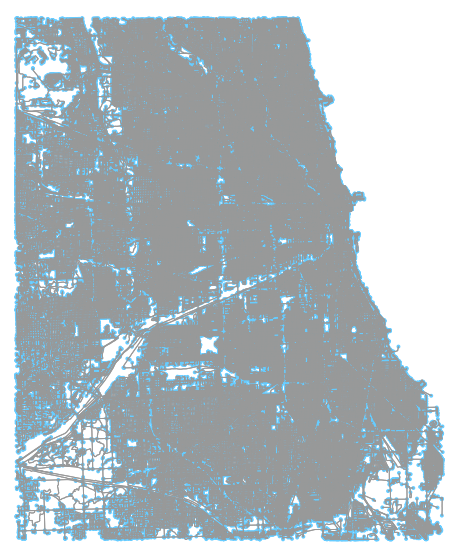

In [26]:
import osmnx as ox

# get the boundary of Chicago neighborhoods
xmin, ymin, xmax, ymax = neighborhoods.to_crs(epsg=4326).total_bounds
G = ox.graph_from_bbox(ymax, ymin, xmax, xmin)
ox.plot_graph(G, fig_height=10);

In [27]:
intersections = ox.graph_to_gdfs(G, nodes=True, edges=False).to_crs(epsg=3857)
# Find the distance to 10 nearest intersections
intersectionXY = get_xy_from_geometry(intersections)
nbrs10.fit(intersectionXY)
intersectionDists, intersectionIndices = nbrs10.kneighbors(stationXY)
joined_3['log_Dist2Intersection_10'] = np.log(intersectionDists[:,0])

### Additional Amenities from OSM

In [28]:
# College
college = osm2gpd.get(xmin, ymin, xmax, ymax, where="amenity=college").to_crs(epsg=3857)
college.head()
# Find the distance to 1 nearest college
collegeXY = get_xy_from_geometry(college)
nbrs1.fit(collegeXY)
collegeDists, collegeIndices = nbrs1.kneighbors(stationXY)
joined_3['log_Dist2College'] = np.log(collegeDists[:,0])

In [29]:
# University
university = osm2gpd.get(xmin, ymin, xmax, ymax, where="amenity=university").to_crs(epsg=3857)
university.head()
# Find the distance to 1 nearest university
universityXY = get_xy_from_geometry(university)
nbrs1.fit(collegeXY)
universityDists, universityIndices = nbrs1.kneighbors(stationXY)
joined_3['log_Dist2University'] = np.log(universityDists[:,0])

In [30]:
# Arts center
arts = osm2gpd.get(xmin, ymin, xmax, ymax, where="amenity=arts_centre").to_crs(epsg=3857)
arts.head()
# Find the distance to 1 nearest arts center
artsXY = get_xy_from_geometry(arts)
nbrs1.fit(artsXY)
artsDists, artsIndices = nbrs1.kneighbors(stationXY)
joined_3['log_Dist2ArtsCenter'] = np.log(artsDists[:,0])

In [31]:
# Community center
community = osm2gpd.get(xmin, ymin, xmax, ymax, where="amenity=community_centre").to_crs(epsg=3857)
community.head()
# Find the distance to 1 nearest community center
communityXY = get_xy_from_geometry(community)
nbrs1.fit(communityXY)
communityDists, communityIndices = nbrs1.kneighbors(stationXY)
joined_3['log_Dist2CommunityCenter'] = np.log(communityDists[:,0])

In [32]:
# Theatre
theatre = osm2gpd.get(xmin, ymin, xmax, ymax, where="amenity=theatre").to_crs(epsg=3857)
theatre.head()
# Find the distance to 1 nearest theatre
theatreXY = get_xy_from_geometry(theatre)
nbrs1.fit(theatreXY)
theatreDists, theatreIndices = nbrs1.kneighbors(stationXY)
joined_3['log_Dist2Theatre'] = np.log(theatreDists[:,0])

In [33]:
# Market Place
market = osm2gpd.get(xmin, ymin, xmax, ymax, where="amenity=marketplace").to_crs(epsg=3857)
market.head()
# Find the distance to 1 nearest market place
marketXY = get_xy_from_geometry(market)
nbrs1.fit(marketXY)
marketDists, marketIndices = nbrs1.kneighbors(stationXY)
joined_3['log_Dist2Market'] = np.log(marketDists[:,0])

### Spatial Lag

In [34]:
nbrs6 = NearestNeighbors(n_neighbors=6)
nbrs6.fit(stationXY)
stationDists, stationIndices = nbrs6.kneighbors(stationXY)

# the total trips for the stations from original data frame
total_start_trips = joined_3['trip_counts'].values

# get the trips for the 5 nearest neighbors (ignoring first match)
neighboring_trips = total_start_trips[stationIndices[:,1:]]

# add to features
joined_3['log_laggedTrips_5'] = np.log(neighboring_trips.mean(axis=1))

### Demographics

In [35]:
from census import Census

In [36]:
c = Census(key=None)
# This is total number of commuters, those commuting by walking, those commuting by public transit
# total population and male population
# bachelor's degree
variables = ("NAME",
             "B01003_001E",
             "B05003_002E",
             "B08134_001E",
             "B08134_101E", 
             "B08134_061E",
             "B06009_005E",
             "B21004_001E")
census_data = pd.DataFrame(c.acs5.state_county_tract(variables, "17", "031", "*"))

# The percent commuting by walking or public transit
census_data["percent_walk"] = 100 * census_data["B08134_101E"] / census_data["B08134_001E"]
census_data["percent_public"] = 100 * census_data["B08134_061E"] / census_data["B08134_001E"]
census_data["percent_male"] = 100 * census_data["B05003_002E"] / census_data["B01003_001E"]
census_data["percent_bachelors"] = 100 * census_data["B06009_005E"] / census_data["B01003_001E"]
census_data["log_medHHInc"] = np.log(census_data["B21004_001E"])

census_data.head()

/Users/zxuanxu/anaconda3/envs/musa-620/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,NAME,B01003_001E,B05003_002E,B08134_001E,B08134_101E,B08134_061E,B06009_005E,B21004_001E,state,county,tract,percent_walk,percent_public,percent_male,percent_bachelors,log_medHHInc
0,"Census Tract 5610, Cook County, Illinois",5541.0,2557.0,2861.0,0.0,366.0,785.0,50272.0,17,031,561000,0.000000,12.792730,46.146905,14.167118,10.825204
1,"Census Tract 6401, Cook County, Illinois",1600.0,670.0,790.0,168.0,188.0,133.0,30203.0,17,031,640100,21.265823,23.797468,41.875000,8.312500,10.315697
2,"Census Tract 6305, Cook County, Illinois",6464.0,3419.0,2847.0,103.0,431.0,82.0,20885.0,17,031,630500,3.617843,15.138743,52.892946,1.268564,9.946786
3,"Census Tract 6111, Cook County, Illinois",2307.0,1253.0,800.0,29.0,185.0,40.0,20481.0,17,031,611100,3.625000,23.125000,54.312961,1.733853,9.927253
4,"Census Tract 6114, Cook County, Illinois",3298.0,1894.0,1287.0,57.0,291.0,88.0,17669.0,17,031,611400,4.428904,22.610723,57.428745,2.668284,9.779567


In [37]:
# merge census data to tracts 
census_data = tracts.merge(
    census_data[['percent_walk','percent_public','percent_male',
                 'percent_bachelors','log_medHHInc',
                 'state','county','tract']],
    left_on=["statefp10", "countyfp10", "tractce10"],
    right_on=["state", "county", "tract"],
)
census_data.head()

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry,percent_walk,percent_public,percent_male,percent_bachelors,log_medHHInc,state,county,tract
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,(POLYGON ((-9754264.404603189 5120652.53575804...,3.386642,46.190028,44.552529,14.721141,10.028533,17,031,842400
1,17,8403,59,Census Tract 8403,59,17031840300,,840300,031,(POLYGON ((-9761169.775256557 5134495.89421121...,1.215067,34.447145,50.574419,7.990809,10.075338,17,031,840300
2,17,8411,34,Census Tract 8411,34,17031841100,,841100,031,(POLYGON ((-9754854.286588391 5138954.58954354...,24.778761,14.363513,49.992670,11.200704,9.620395,17,031,841100
3,17,8412,31,Census Tract 8412,31,17031841200,,841200,031,(POLYGON ((-9761398.53680929 5139387.107396653...,8.182963,32.438103,47.115570,10.997492,10.032057,17,031,841200
4,17,8390,32,Census Tract 8390,32,17031839000,,839000,031,(POLYGON ((-9755274.517668668 5142196.85765954...,32.483731,30.386840,40.529150,29.559822,10.915270,17,031,839000


In [38]:
# merge census data to stations 
merged = joined_3.merge(
    census_data[['geoid10','percent_walk','percent_public','percent_male',
                'percent_bachelors','log_medHHInc']],
    on='geoid10',how='left')

merged['log_medHHInc'] = merged['log_medHHInc'].fillna(0)
merged['log_trip_counts'] = np.log(merged['trip_counts'])
merged.head()

,id,total_docks,station_name,status,geometry,from_station_id,trip_counts,name10,geoid10,neighborhood,...,log_Dist2CommunityCenter,log_Dist2Theatre,log_Dist2Market,log_laggedTrips_5,percent_walk,percent_public,percent_male,percent_bachelors,log_medHHInc,log_trip_counts
0,2,39,Buckingham Fountain,In Service,POINT (-9753874.787486579 5142499.336427348),2,9422,3204,17031320400,Grant Park,...,8.553476,6.143084,7.528726,9.733067,53.419593,24.768946,47.616040,10.798863,8.778942,9.150803
1,3,55,Shedd Aquarium,In Service,POINT (-9753296.74770876 5141111.239290465),3,24757,3301,17031330100,Museum Campus,...,8.768318,7.439378,8.119296,9.695737,10.814983,27.399041,46.768341,29.155930,11.130171,10.116864
2,4,23,Burnham Harbor,In Service,POINT (-9753073.286053874 5139473.34429373),4,11964,3301,17031330100,Museum Campus,...,8.946823,6.560039,8.244589,8.939686,10.814983,27.399041,46.768341,29.155930,11.130171,9.389657
3,5,23,State St & Harrison St,In Service,POINT (-9754672.724497592 5142131.825102462),5,8849,8390,17031839000,Printers Row,...,8.458355,6.003502,7.685427,9.370638,32.483731,30.386840,40.529150,29.559822,10.915270,9.088060
4,6,39,Dusable Harbor,In Service,POINT (-9753013.730126299 5144064.003959995),6,14076,814.03,17031081403,Loop,...,8.610259,6.902188,7.236149,10.347102,48.464780,15.271925,55.808775,34.813360,11.340202,9.552226


# 2 Exploratory Analysis and Maps

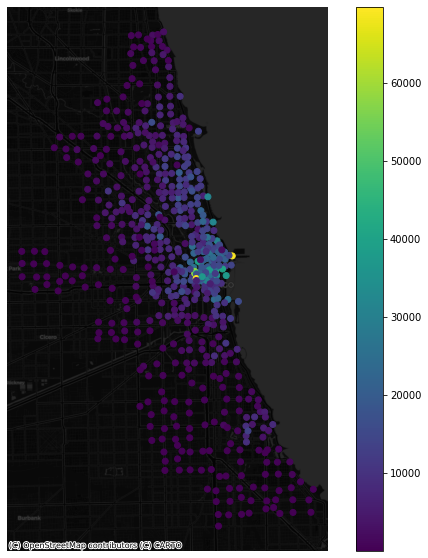

In [39]:
import contextily as ctx
fig, ax = plt.subplots(figsize=(10,10))

# stations
merged.dropna().plot(ax=ax, column='trip_counts', legend=True)

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=neighborhoods.crs, url=ctx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

## Correlation Plot

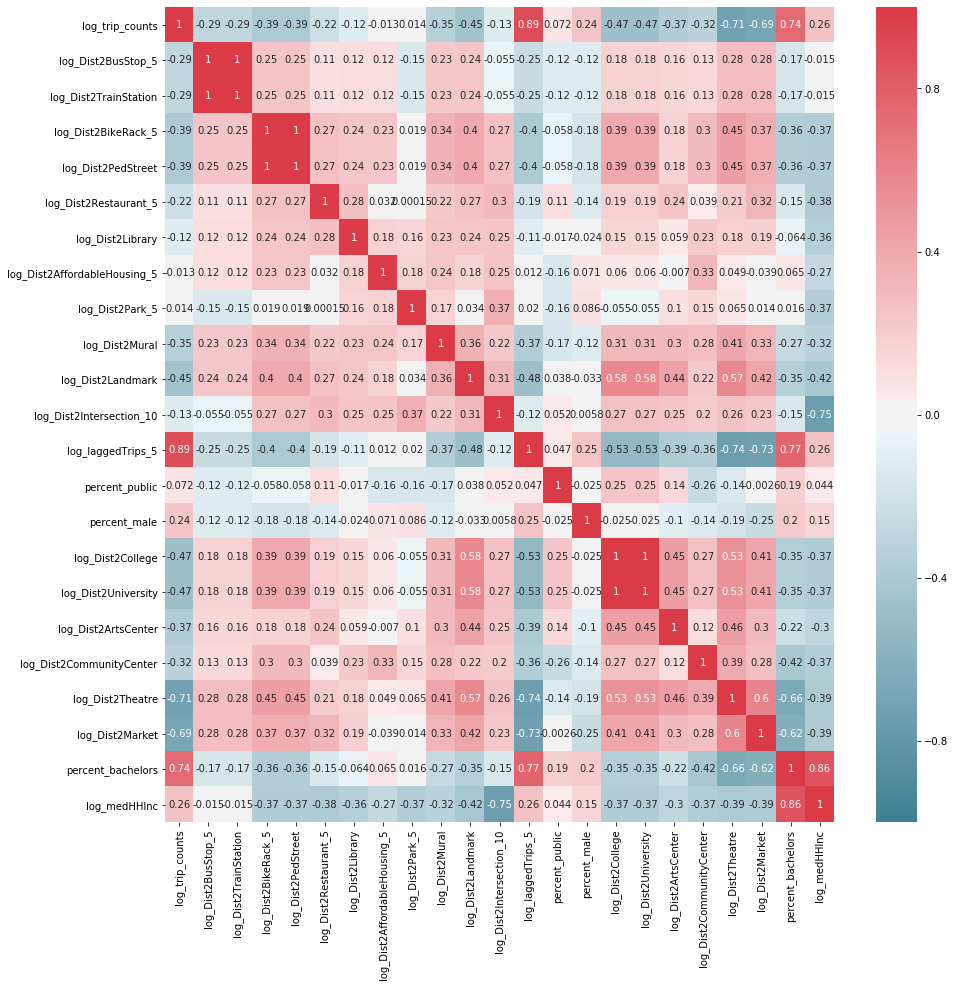

In [40]:
import seaborn as sns
feature_cols = [
    'log_trip_counts',
    'total_docks',
    'log_Dist2BusStop_5',
    'log_Dist2TrainStation',
    'log_Dist2BikeRack_5',
    'log_Dist2PedStreet', 
    'log_Dist2Restaurant_5', 
    'log_Dist2Library',
    'log_Dist2AffordableHousing_5', 
    'log_Dist2Park_5',
    'log_Dist2Mural',
    'log_Dist2Landmark', 
    'log_Dist2Intersection_10', 
    'log_laggedTrips_5', 
    'percent_public',
    'percent_male',
    'log_Dist2College', 
    'log_Dist2University',
    'log_Dist2ArtsCenter', 
    'log_Dist2CommunityCenter', 
    'log_Dist2Theatre',
    'log_Dist2Market','percent_bachelors', 'log_medHHInc']

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(merged[feature_cols].corr(), cmap=cmap, annot=True, vmin=-1, vmax=1);

From the correlation plot, it's obvious that there is correlation between log_Dist2BusStop_5 and log_Dist2TrainStation, log_Dist2BikeRack_5 and log_Dist2PedStreet, log_Dist2College and log_Dist2University, and percent_bachelors and log_medHHInc.

Therefore, considering independent variable's correlation with the dependent variable, we eliminated log_Dist2TrainStation, log_Dist2PedStreet, log_Dist2University, and log_medHHInc from the model.

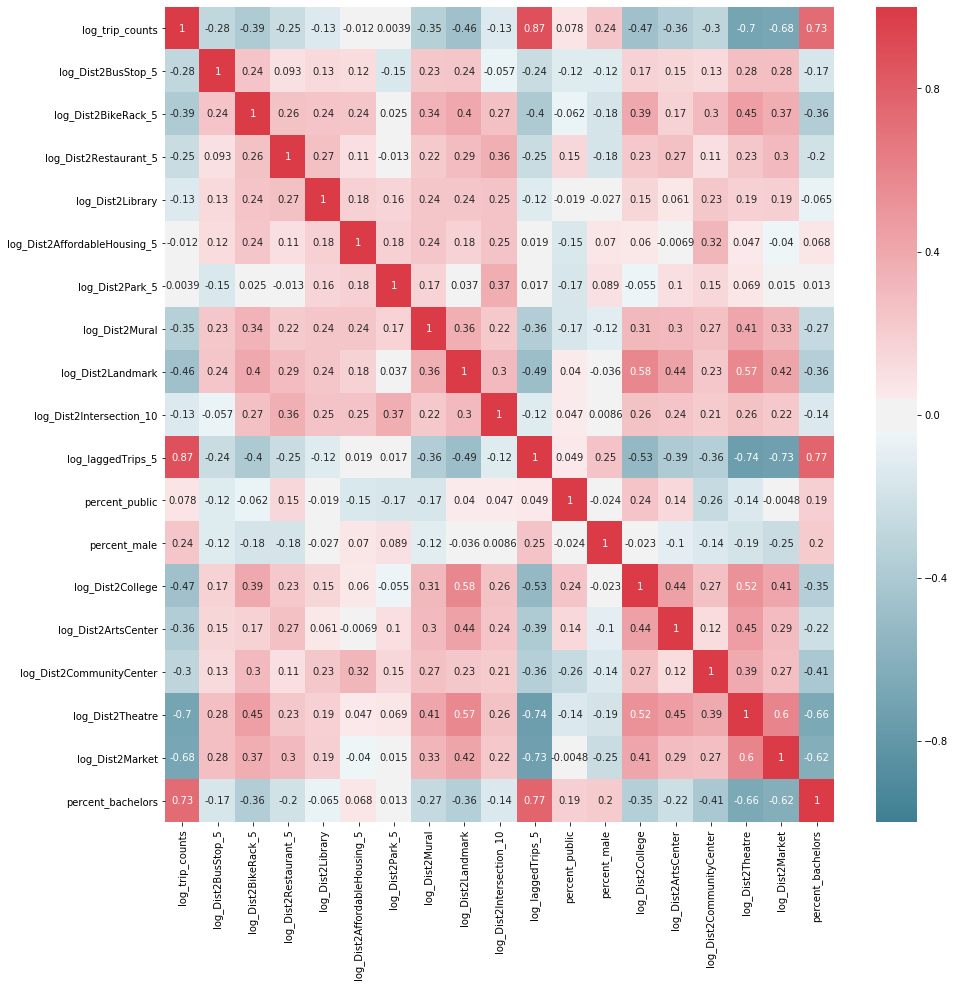

In [310]:
feature_cols = [
    'log_trip_counts',
    'total_docks',
    'log_Dist2BusStop_5',
    'log_Dist2BikeRack_5',
    'log_Dist2Restaurant_5', 
    'log_Dist2Library',
    'log_Dist2AffordableHousing_5', 
    'log_Dist2Park_5',
    'log_Dist2Mural',
    'log_Dist2Landmark', 
    'log_Dist2Intersection_10', 
    'log_laggedTrips_5', 
    'percent_public',
    'percent_male',
    'log_Dist2College', 
    'log_Dist2ArtsCenter', 
    'log_Dist2CommunityCenter', 
    'log_Dist2Theatre',
    'log_Dist2Market','percent_bachelors']

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(merged[feature_cols].corr(), cmap=cmap, annot=True, vmin=-1, vmax=1);

## Histogram of Dependent Variable

### Original

Text(0.5, 1.0, 'Histogram of Trip Counts')

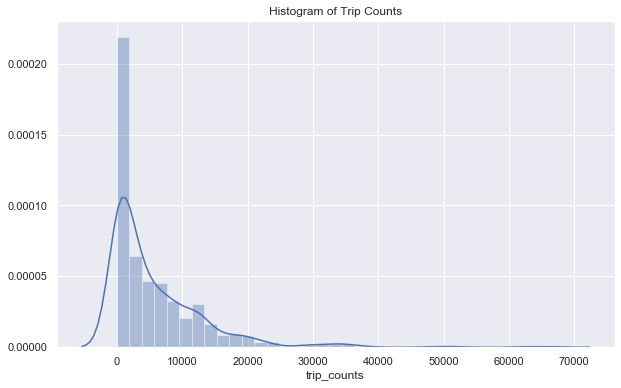

In [314]:
f, ax = plt.subplots(figsize=(10, 6))
sns.set(color_codes=True)
sns.distplot(merged['trip_counts'], kde=True);
ax.set_title('Histogram of Trip Counts')

### Log transformed

Text(0.5, 1.0, 'Histogram of Log Trip Counts')

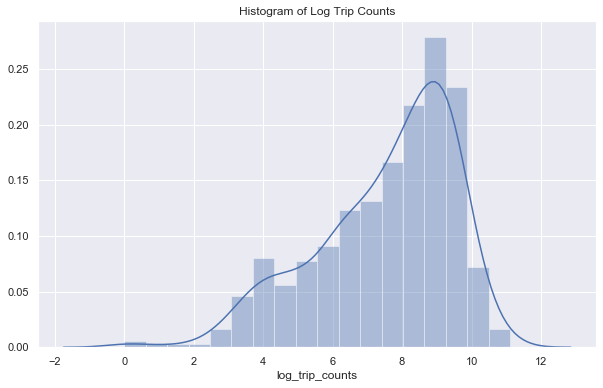

In [315]:
f, ax = plt.subplots(figsize=(10, 6))
sns.set(color_codes=True)
sns.distplot(merged['log_trip_counts'], kde=True);
ax.set_title('Histogram of Log Trip Counts')

Therefore, we chose the log-transformed trip counts of each station as the dependent variable of our linear regression model.

# 3 Model at Station Level
## Perform test/train split

In [111]:
# Remove unnecessary columns
final = merged.drop(columns=['id', 'station_name', 'status', 'geometry',
       'from_station_id', 'name10', 'geoid10'])

final = final.dropna()

# Split the data 70/30
train_set, test_set = train_test_split(
    final,
    test_size=0.3,
    random_state=42,
)

# the target labels
y_train = train_set["log_trip_counts"]
y_test = test_set["log_trip_counts"]

In [112]:
feature_cols = [
    'ifCBD',
    'neighborhood',
    'total_docks',
    'log_Dist2BusStop_5',
    'log_Dist2TrainStation',
    'log_Dist2BikeRack_5',
    'log_Dist2PedStreet', 
    'log_Dist2Restaurant_5', 
    'log_Dist2Library',
    'log_Dist2AffordableHousing_5', 
    'log_Dist2Park_5',
    'log_Dist2Mural',
    'log_Dist2Landmark', 
    'log_Dist2Intersection_10', 
    'log_laggedTrips_5', 
    'log_Dist2College', 
    'log_Dist2University',
    'log_Dist2ArtsCenter', 
    'log_Dist2CommunityCenter', 
    'log_Dist2Theatre',
    'log_Dist2Market',
    'percent_public',
    'percent_male',
    'percent_bachelors'
]

num_cols = [
    'ifCBD',
    'total_docks',
    'log_Dist2BusStop_5',
    'log_Dist2TrainStation',
    'log_Dist2BikeRack_5',
    'log_Dist2PedStreet', 
    'log_Dist2Restaurant_5', 
    'log_Dist2Library',
    'log_Dist2AffordableHousing_5', 
    'log_Dist2Park_5',
    'log_Dist2Mural',
    'log_Dist2Landmark', 
    'log_Dist2Intersection_10', 
    'log_laggedTrips_5', 
    'log_Dist2College', 
    'log_Dist2University',
    'log_Dist2ArtsCenter', 
    'log_Dist2CommunityCenter', 
    'log_Dist2Theatre',
    'log_Dist2Market',
    'percent_public',
    'percent_male',
    'percent_bachelors'
]

cat_cols = [
    'neighborhood'
]

x_train = train_set[feature_cols]
x_test = test_set[feature_cols]

In [113]:
model_name = "randomforestregressor"
param_grid = {
    f"{model_name}__n_estimators": [5, 10, 15, 20, 30, 50, 100, 200],
    f"{model_name}__max_depth": [2, 5, 7, 9, 13, 21, 33, 51, 100],
}

param_grid

{'randomforestregressor__n_estimators': [5, 10, 15, 20, 30, 50, 100, 200],
 'randomforestregressor__max_depth': [2, 5, 7, 9, 13, 21, 33, 51, 100]}

In [114]:
# Set up the column transformer with two transformers
# Scale the numerical columns and one-hot 
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Initialize the pipeline
# NOTE: only use 10 estimators here so it will run in a reasonable time
regr = make_pipeline(
    preprocessor, RandomForestRegressor(n_estimators=20, random_state=42)
)

In [115]:
# Create the grid and use 3-fold CV
grid = GridSearchCV(regr, param_grid, cv=3)

# Run the search
grid.fit(pd.DataFrame(data=x_train.values,columns=feature_cols), y_train);

In [116]:
# Evaluate the best random forest model
best_random = grid.best_estimator_
best_random.score(x_test, y_test)

0.8055953745511416

In [117]:
# The one-hot step
preprocessor.fit_transform(x_train)
ohe = preprocessor.named_transformers_['cat']

# One column for each category type!
ohe_cols = ohe.get_feature_names()

# Full list of columns is numerical + one-hot
features = num_cols + list(ohe_cols)

In [120]:
# Full list of columns is numerical + one-hot
importance = pd.DataFrame(
    {"Feature": features, "Importance": regressor.feature_importances_}
)

# Sort importance in descending order and get the top
importance = importance.sort_values("Importance", ascending=False).iloc[:50]

# Plot
importance.hvplot.barh(x="Feature", y="Importance", flip_yaxis=True, height=500)

:Bars   [Feature]   (Importance)

## MAE and MAPE

In [93]:
def evaluate(model, test_set, y_test):
    """
    Given a model and test features/targets, print out the 
    mean absolute error and accuracy
    """
    # Make the predictions
    predictions = model.predict(test_set)
    predictions = np.exp(predictions)

    # Absolute error
    errors = abs(predictions - np.exp(y_test))
    avg_error = np.mean(errors)

    # Mean absolute percentage error
    mape = 100 * np.mean(errors / np.exp(y_test))

    # Accuracy
    accuracy = 100 - mape

    print("Model Performance")
    print(f"Average Absolute Error: {avg_error:0.4f}")
    print(f"MAPE = {mape:0.2f}%.")

    return mape

In [121]:
# Calculate the MAPE and MAE of the model
evaluate(best_random,x_test,y_test)

Model Performance
Average Absolute Error: 2701.6542
MAPE = 150.75%.


150.7482438219328

## Spatial structure of predictions

In [202]:
# Extract the test data from the original dataset
# This will include the geometry data
X = merged.loc[x_test.index]

In [203]:
# Predictions for log of total trip counts
log_predictions = best_random.predict(x_test)

# Convert the predicted test values from log
X['prediction'] = np.exp(log_predictions)

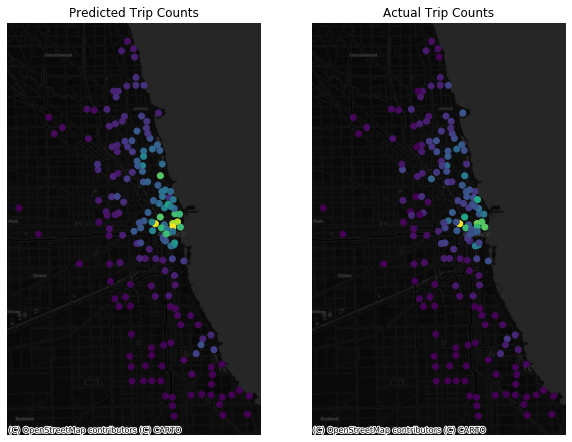

In [204]:
# Plot two columns
fig, axs = plt.subplots(ncols=2, figsize=(10,10))

# Predicted values
X.plot(ax=axs[0], column='prediction')
ctx.add_basemap(ax=axs[0], crs=X.crs, url=ctx.providers.CartoDB.DarkMatter)
axs[0].set_title("Predicted Trip Counts")

# Actual values
X.plot(ax=axs[1], column='trip_counts')
ctx.add_basemap(ax=axs[1], crs=X.crs, url=ctx.providers.CartoDB.DarkMatter)
axs[1].set_title("Actual Trip Counts")


axs[0].set_axis_off()
axs[1].set_axis_off()

Our model successfully captured the general trend of trip counts within CBD and outside CBD. Meanwhile, the model does a great job in predicting the trip counts outside the CBD. For the stations with the highest trip counts in CBD, the predicted results are relatively more accurate, compared to the busiest stations outside CBD.

# 4 Model at Fishnet Level

In [67]:
# Create fishnet for Chicago
from shapely.geometry import Polygon

xmin,ymin,xmax,ymax = neighborhoods.to_crs(epsg=3857).total_bounds

length = 110
wide = 110

cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), wide))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), length))
rows.reverse()

polygons = []
for x in cols:
    for y in rows:
        polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y-length), (x, y-length)]) )

grid = gpd.GeoDataFrame({'geometry':polygons})
len(grid)

216815

## Feature Engineering

In [68]:
# Join trip counts to each grid cell based on geospatial location
fishnet_data = gpd.sjoin(
    station_trip,
    grid,
    how='right',
    op='within'
).drop(columns=['index_left'])

fishnet_data.head()

/Users/zxuanxu/anaconda3/envs/musa-620/lib/python3.6/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:3857', 'no_defs': True} != None)
  '(%s != %s)' % (left_df.crs, right_df.crs))


,id,total_docks,station_name,status,from_station_id,trip_counts,geometry
index_right,,,,,,,
86179,524,7,Austin Blvd & Chicago Ave,In Service,524,128.0,"POLYGON ((-9771079 5145281, -9770969 5145281, ..."
86188,532,11,Austin Blvd & Lake St,In Service,532,415.0,"POLYGON ((-9771079 5144291, -9770969 5144291, ..."
86199,544,11,Austin Blvd & Madison St,In Service,544,163.0,"POLYGON ((-9771079 5143081, -9770969 5143081, ..."
90824,531,11,Central Ave & Lake St,In Service,531,106.0,"POLYGON ((-9770089 5144181, -9769979 5144181, ..."
91329,550,11,Central Ave & Chicago Ave,In Service,550,43.0,"POLYGON ((-9769979 5145281, -9769869 5145281, ..."


In [69]:
# join fishnet to census tracts
joined1 = gpd.sjoin(
    fishnet_data,
    tracts[['geometry','name10','geoid10']],
    how='left',
    op='intersects'
).drop(
    columns=['index_right']
).reset_index().drop_duplicates(subset=['index'],keep='first')
joined1.head()

,index,id,total_docks,station_name,status,from_station_id,trip_counts,geometry,name10,geoid10
0,86179,524,7,Austin Blvd & Chicago Ave,In Service,524,128.0,"POLYGON ((-9771079 5145281, -9770969 5145281, ...",2514,17031251400
2,86188,532,11,Austin Blvd & Lake St,In Service,532,415.0,"POLYGON ((-9771079 5144291, -9770969 5144291, ...",2514,17031251400
3,86199,544,11,Austin Blvd & Madison St,In Service,544,163.0,"POLYGON ((-9771079 5143081, -9770969 5143081, ...",2521.01,17031252101
5,90824,531,11,Central Ave & Lake St,In Service,531,106.0,"POLYGON ((-9770089 5144181, -9769979 5144181, ...",2520,17031252000
7,91329,550,11,Central Ave & Chicago Ave,In Service,550,43.0,"POLYGON ((-9769979 5145281, -9769869 5145281, ...",2515,17031251500


In [70]:
# join fishnet to neighborhoods
joined3 = gpd.sjoin(
    neighborhoods[['geometry','pri_neigh']],
    joined1,
    how='right',
    op='intersects'
).drop(
    columns=['index_left']
).reset_index().drop_duplicates(
    subset=['index'],keep='first'
).rename(columns={'pri_neigh':'neighborhood'})
joined3.head()

,index_right,neighborhood,index,id,total_docks,station_name,status,from_station_id,trip_counts,geometry,name10,geoid10
0,189496,Grand Boulevard,173832,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-9752379 5133951, -9752269 5133951, ...",3801,17031380100
2,188362,Grand Boulevard,172802,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-9752599 5133951, -9752489 5133951, ...",3801,17031380100
3,188925,Grand Boulevard,173317,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-9752489 5133951, -9752379 5133951, ...",3801,17031380100
4,188361,Grand Boulevard,172801,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-9752599 5134061, -9752489 5134061, ...",3801,17031380100
5,188924,Grand Boulevard,173316,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-9752489 5134061, -9752379 5134061, ...",3801,17031380100


### Distance to amenities

In [73]:
from numpy import inf

fishnetXY = list(zip(joined3.geometry.centroid.x,
                    joined3.geometry.centroid.y))
# Find the distance to downtown Chicago
downtownXY = list(zip(CBD.geometry.centroid.x,
                     CBD.geometry.centroid.y))
nbrs1.fit(downtownXY)
downtownDists, downtownIndices = nbrs1.kneighbors(fishnetXY)
joined3['log_Dist2downtown'] = np.log(downtownDists[:,0])
# Find the distance to 5 nearest bus stops
busXY = get_xy_from_geometry(bus_stops)
nbrs5.fit(busXY)
busDists, busIndices = nbrs5.kneighbors(fishnetXY)
joined3['log_Dist2BusStop_5'] = np.log(busDists[:,0])

# Find the distance to 1 nearest train stations
trainXY = get_xy_from_geometry(train_stations)
nbrs1.fit(trainXY)
trainDists, trainIndices = nbrs1.kneighbors(fishnetXY)
joined3['log_Dist2TrainStation'] = np.log(trainDists[:,0])

# Find the distance to 5 nearest bus racks
rackXY = get_xy_from_geometry(bike_racks)
nbrs5.fit(rackXY)
rackDists, rackIndices = nbrs5.kneighbors(fishnetXY)
joined3['log_Dist2BikeRack_5'] = np.log(rackDists[:,0])

# Find the distance to 1 nearest pedestrian street
pedXY = list(zip(pedestrian_streets.geometry.centroid.x,
                    pedestrian_streets.geometry.centroid.y))
nbrs1.fit(pedXY)
pedDists, pedIndices = nbrs5.kneighbors(fishnetXY)
joined3['log_Dist2PedStreet'] = np.log(pedDists[:,0])

# Find the distance to 5 nearest restaurants
restaurantXY = get_xy_from_geometry(restaurant)
nbrs5.fit(restaurantXY)
restDists, restIndices = nbrs5.kneighbors(fishnetXY)
joined3['log_Dist2Restaurant_5'] = np.log(restDists[:,0])

# Find the distance to 1 nearest library
libraryXY = get_xy_from_geometry(library)
nbrs1.fit(libraryXY)
libraryDists, libraryIndices = nbrs1.kneighbors(fishnetXY)
joined3['log_Dist2Library'] = np.log(libraryDists[:,0])

# Find the distance to 5 nearest affordable housing projects
housingXY = get_xy_from_geometry(housing)
nbrs5.fit(housingXY)
housingDists, housingIndices = nbrs5.kneighbors(fishnetXY)
joined3['log_Dist2AffordableHousing_5'] = np.log(housingDists[:,0])

# Find the distance to 5 nearest parks
parkXY = get_xy_from_geometry(park)
nbrs5.fit(parkXY)
parkDists, parkIndices = nbrs5.kneighbors(fishnetXY)
joined3['log_Dist2Park_5'] = np.log(parkDists[:,0])

# Find the distance to 1 nearest mural destination
muralXY = get_xy_from_geometry(mural)
nbrs1.fit(muralXY)
muralDists, muralIndices = nbrs1.kneighbors(fishnetXY)
joined3['log_Dist2Mural'] = np.log(muralDists[:,0])

# Find the distance to 1 nearest landmark
landmarkXY = get_xy_from_geometry(landmark)
nbrs1.fit(landmarkXY)
landmarkDists, landmarkIndices = nbrs1.kneighbors(fishnetXY)
joined3['log_Dist2Landmark'] = np.log(landmarkDists[:,0])

# Find the distance to 1 nearest college
collegeXY = get_xy_from_geometry(college)
nbrs1.fit(collegeXY)
collegeDists, collegeIndices = nbrs1.kneighbors(fishnetXY)
joined3['log_Dist2College'] = np.log(collegeDists[:,0])

# Find the distance to 1 nearest university
universityXY = get_xy_from_geometry(university)
nbrs1.fit(collegeXY)
universityDists, universityIndices = nbrs1.kneighbors(fishnetXY)
joined3['log_Dist2University'] = np.log(universityDists[:,0])

# Find the distance to 1 nearest arts center
artsXY = get_xy_from_geometry(arts)
nbrs1.fit(artsXY)
artsDists, artsIndices = nbrs1.kneighbors(fishnetXY)
joined3['log_Dist2ArtsCenter'] = np.log(artsDists[:,0])

# Find the distance to 1 nearest community center
communityXY = get_xy_from_geometry(community)
nbrs1.fit(communityXY)
communityDists, communityIndices = nbrs1.kneighbors(fishnetXY)
joined3['log_Dist2CommunityCenter'] = np.log(communityDists[:,0])

# Find the distance to 1 nearest theatre
theatreXY = get_xy_from_geometry(theatre)
nbrs1.fit(theatreXY)
theatreDists, theatreIndices = nbrs1.kneighbors(fishnetXY)
joined3['log_Dist2Theatre'] = np.log(theatreDists[:,0])

# Find the distance to 1 nearest market place
marketXY = get_xy_from_geometry(market)
nbrs1.fit(marketXY)
marketDists, marketIndices = nbrs1.kneighbors(fishnetXY)
joined3['log_Dist2Market'] = np.log(marketDists[:,0])

# Find the trip counts of 5 nearest stations
nbrs5.fit(stationXY)
stationDists, stationIndices = nbrs5.kneighbors(fishnetXY)

# the total trips for the stations from original data frame
total_start_trips = station_trip['trip_counts'].values

# get the trips for the 5 nearest neighbors (ignoring first match)
neighboring_trips = total_start_trips[stationIndices[:,0:]]

# add to features
joined3['log_laggedTrips_5'] = np.log(neighboring_trips.mean(axis=1))
joined3['log_laggedTrips_5'][joined3['log_laggedTrips_5']==-inf] = 0

# Find the distance to 10 nearest intersections
intersectionXY = get_xy_from_geometry(intersections)
nbrs10.fit(intersectionXY)
intersectionDists, intersectionIndices = nbrs10.kneighbors(fishnetXY)
joined3['log_Dist2Intersection_10'] = np.log(intersectionDists[:,0])

/Users/zxuanxu/anaconda3/envs/musa-620/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Demographics

In [74]:
merged_new = joined3.merge(
    census_data[['geoid10','percent_walk','percent_public','percent_male',
                'percent_bachelors','log_medHHInc']],
    on='geoid10',how='left')

merged_new['log_medHHInc'] = merged['log_medHHInc'].fillna(0)
merged_new.head()

,index_right,neighborhood,index,id,total_docks,station_name,status,from_station_id,trip_counts,geometry,...,log_Dist2CommunityCenter,log_Dist2Theatre,log_Dist2Market,log_laggedTrips_5,log_Dist2Intersection_10,percent_walk,percent_public,percent_male,percent_bachelors,log_medHHInc
0,189496,Grand Boulevard,173832,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-9752379 5133951, -9752269 5133951, ...",...,8.307660,8.214492,8.911972,6.820671,3.844093,13.653846,22.884615,48.550725,11.904762,8.778942
1,188362,Grand Boulevard,172802,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-9752599 5133951, -9752489 5133951, ...",...,8.286148,8.232785,8.893929,6.653895,4.003933,13.653846,22.884615,48.550725,11.904762,11.130171
2,188925,Grand Boulevard,173317,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-9752489 5133951, -9752379 5133951, ...",...,8.296644,8.223287,8.902920,6.653895,4.647203,13.653846,22.884615,48.550725,11.904762,11.130171
3,188361,Grand Boulevard,172801,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-9752599 5134061, -9752489 5134061, ...",...,8.311635,8.259992,8.881747,6.544200,3.455637,13.653846,22.884615,48.550725,11.904762,10.915270
4,188924,Grand Boulevard,173316,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-9752489 5134061, -9752379 5134061, ...",...,8.321615,8.251001,8.890958,6.713199,4.566723,13.653846,22.884615,48.550725,11.904762,11.340202


## Exploratory Analysis
### Maps of independent variables
#### Log-transformed Distance to the 5 nearest restaurants

In [50]:
merged_new.columns

Index(['index_right', 'neighborhood', 'index', 'id', 'total_docks',
       'station_name', 'status', 'from_station_id', 'trip_counts', 'geometry',
       'name10', 'geoid10', 'log_Dist2downtown', 'log_Dist2BusStop_5',
       'log_Dist2TrainStation', 'log_Dist2BikeRack_5', 'log_Dist2PedStreet',
       'log_Dist2Restaurant_5', 'log_Dist2Library',
       'log_Dist2AffordableHousing_5', 'log_Dist2Park_5', 'log_Dist2Mural',
       'log_Dist2Landmark', 'log_Dist2College', 'log_Dist2University',
       'log_Dist2ArtsCenter', 'log_Dist2CommunityCenter', 'log_Dist2Theatre',
       'log_Dist2Market', 'log_laggedTrips_5', 'log_Dist2Intersection_10',
       'percent_walk', 'percent_public', 'percent_male', 'percent_bachelors',
       'log_medHHInc'],
      dtype='object')

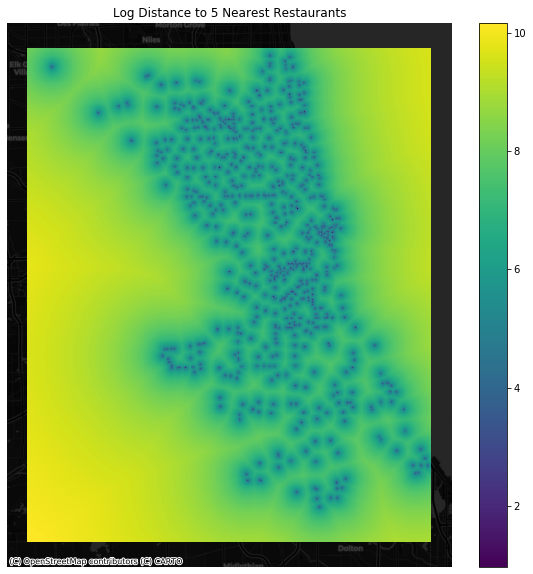

In [53]:
# Plot set up
fig, ax = plt.subplots(figsize=(10,10))

# Predicted values
merged_new.plot(ax=ax, column='log_Dist2Restaurant_5',cmap='viridis',edgecolor='none',legend=True)
ctx.add_basemap(ax=ax, crs=merged_new.crs, url=ctx.providers.CartoDB.DarkMatter)
ax.set_title("Log Distance to 5 Nearest Restaurants")

ax.set_axis_off()

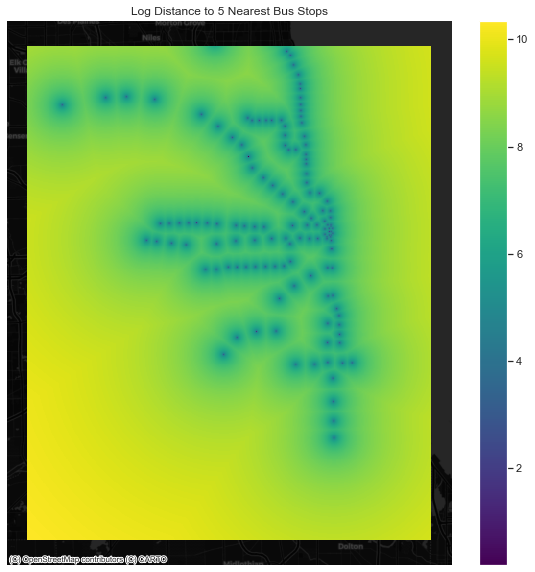

In [122]:
# Plot set up
fig, ax = plt.subplots(figsize=(10,10))

# Predicted values
merged_new.plot(ax=ax, column='log_Dist2BusStop_5',cmap='viridis',edgecolor='none',legend=True)
ctx.add_basemap(ax=ax, crs=merged_new.crs, url=ctx.providers.CartoDB.DarkMatter)
ax.set_title("Log Distance to 5 Nearest Bus Stops")

ax.set_axis_off()

#### Log-tranformed Distance to the 10 Nearest Intersections

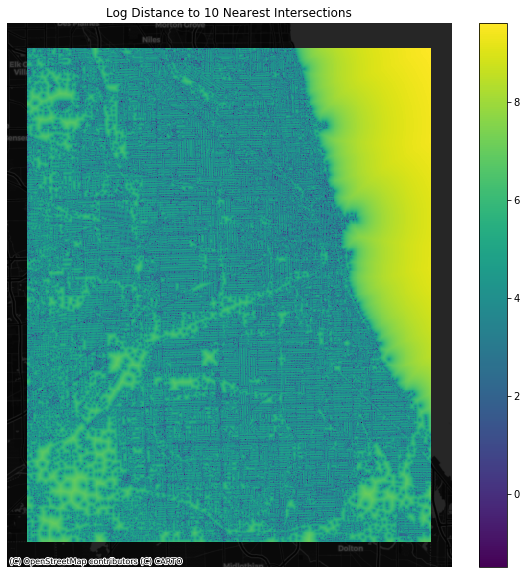

In [54]:
# Plot set up
fig, ax = plt.subplots(figsize=(10,10))

# Predicted values
merged_new.plot(ax=ax, column='log_Dist2Intersection_10',cmap='viridis',edgecolor='none',legend=True)
ctx.add_basemap(ax=ax, crs=merged_new.crs, url=ctx.providers.CartoDB.DarkMatter)
ax.set_title("Log Distance to 10 Nearest Intersections")

ax.set_axis_off()

#### Log-transformed Trip Lag of 5 Nearest Stations

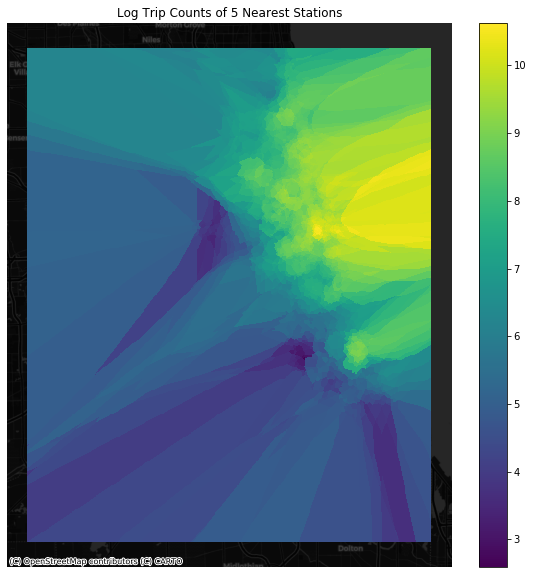

In [75]:
# Plot set up
fig, ax = plt.subplots(figsize=(10,10))

# Predicted values
merged_new.plot(ax=ax, column='log_laggedTrips_5',cmap='viridis',edgecolor='none',legend=True)
ctx.add_basemap(ax=ax, crs=merged_new.crs, url=ctx.providers.CartoDB.DarkMatter)
ax.set_title("Log Trip Counts of 5 Nearest Stations")

ax.set_axis_off()

## Create the model-build data set (grid with station) & predict data set (grid without station)

In [80]:
grid_with = merged_new.loc[merged_new['id'].notna()]
grid_without = merged_new.loc[merged_new['id'].isnull()]

### Scatterplots of independent variables

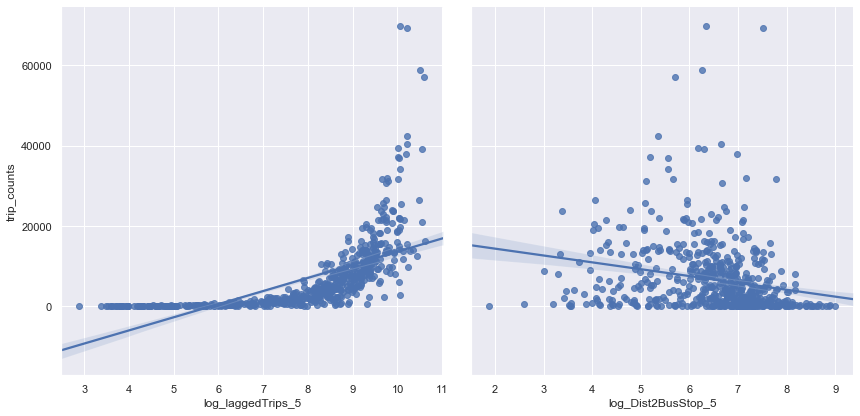

In [82]:
sns.set(color_codes=True)
g = sns.PairGrid(grid_with, 
                 y_vars=['trip_counts'],
                 x_vars=['log_laggedTrips_5',
                         'log_Dist2BusStop_5'],
                height=6,
                aspect=1,
                palette='Blues')
g.map(sns.regplot)
g.savefig('scatterplot.png')

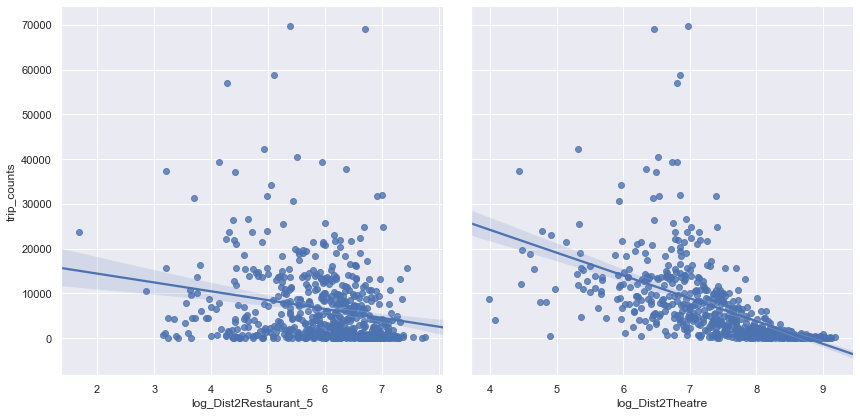

In [81]:
sns.set(color_codes=True)
g = sns.PairGrid(grid_with, 
                 y_vars=['trip_counts'],
                 x_vars=['log_Dist2Restaurant_5',
                         'log_Dist2Theatre'],
                height=6,
                aspect=1,
                palette='Blues')
g.map(sns.regplot)
g.savefig('scatterplot2.png')

### Correlation Plots

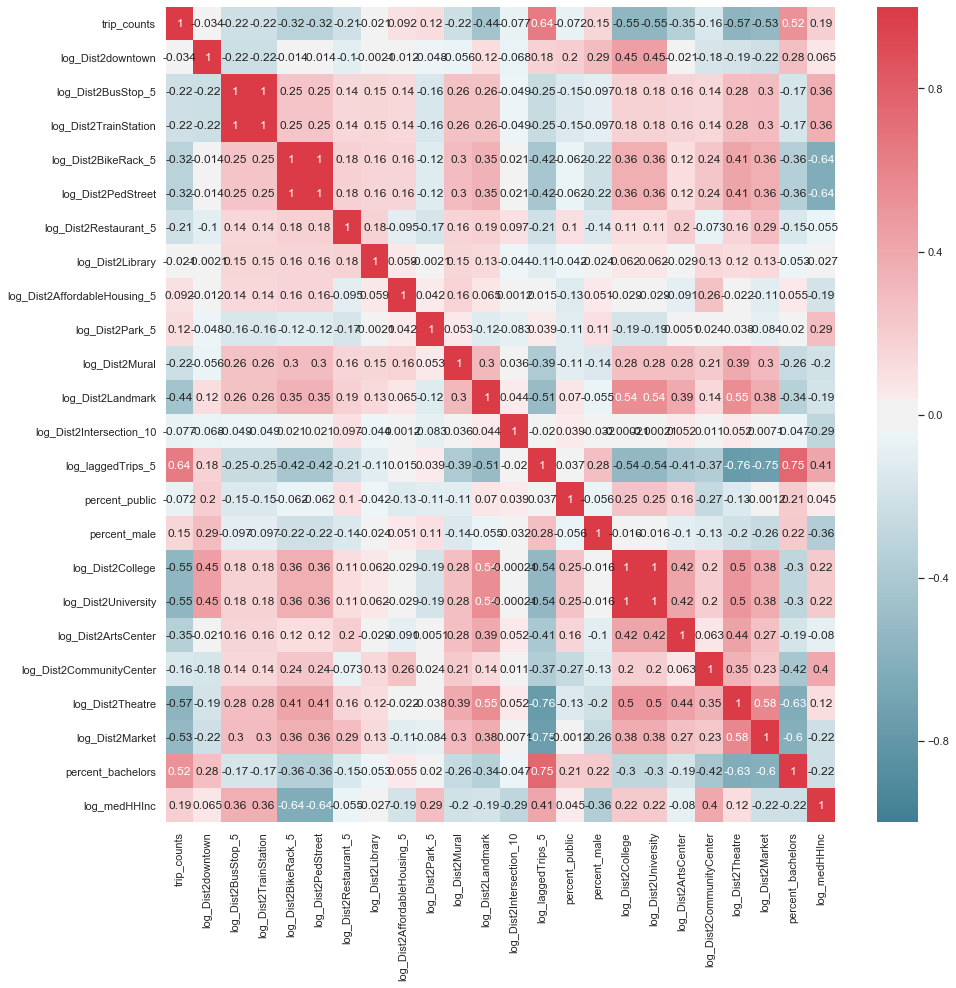

In [83]:
feature_cols = [
    'trip_counts',
    'total_docks',
    'log_Dist2downtown',
    'log_Dist2BusStop_5',
    'log_Dist2TrainStation',
    'log_Dist2BikeRack_5',
    'log_Dist2PedStreet', 
    'log_Dist2Restaurant_5', 
    'log_Dist2Library',
    'log_Dist2AffordableHousing_5', 
    'log_Dist2Park_5',
    'log_Dist2Mural',
    'log_Dist2Landmark', 
    'log_Dist2Intersection_10', 
    'log_laggedTrips_5', 
    'percent_public',
    'percent_male',
    'log_Dist2College', 
    'log_Dist2University',
    'log_Dist2ArtsCenter', 
    'log_Dist2CommunityCenter', 
    'log_Dist2Theatre',
    'log_Dist2Market','percent_bachelors', 'log_medHHInc']

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(grid_with[feature_cols].corr(), cmap=cmap, annot=True, vmin=-1, vmax=1);
plt.savefig('heatmap1.png')

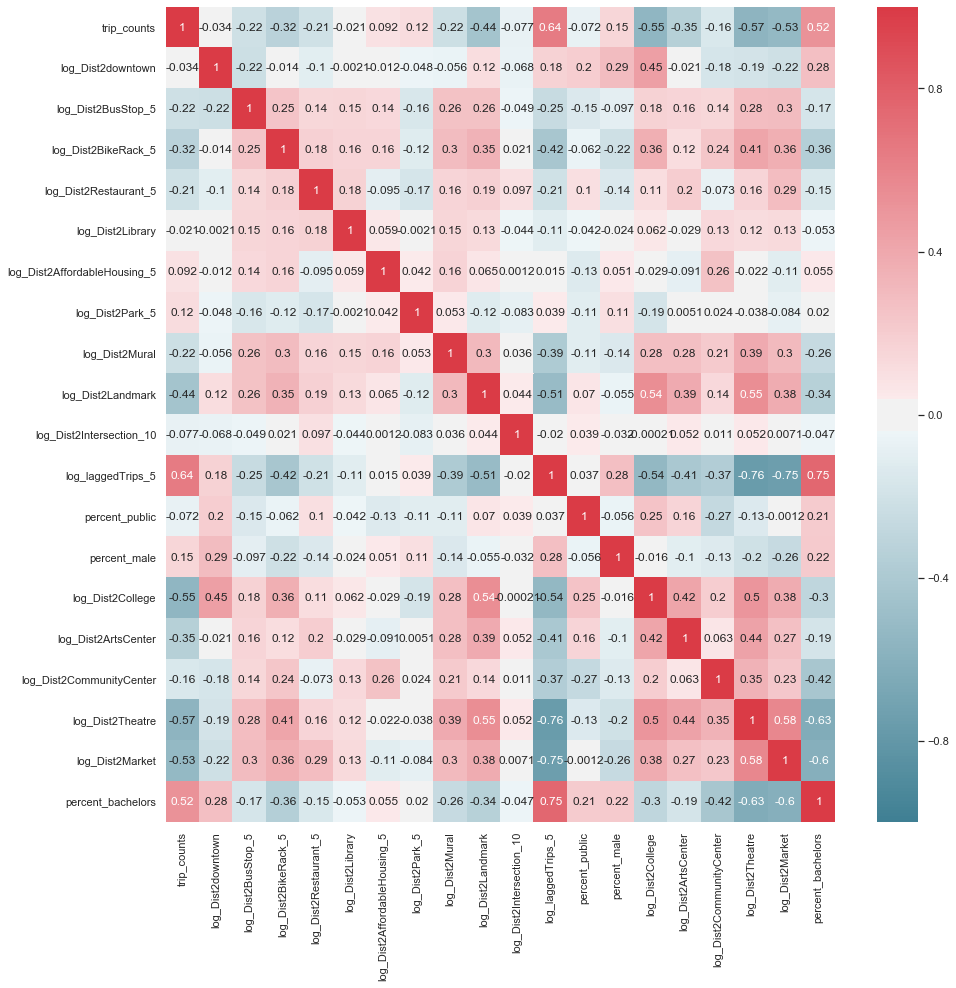

In [84]:
feature_cols = [
    'trip_counts',
    'total_docks',
    'log_Dist2downtown',
    'log_Dist2BusStop_5',
    'log_Dist2BikeRack_5',
    'log_Dist2Restaurant_5', 
    'log_Dist2Library',
    'log_Dist2AffordableHousing_5', 
    'log_Dist2Park_5',
    'log_Dist2Mural',
    'log_Dist2Landmark', 
    'log_Dist2Intersection_10', 
    'log_laggedTrips_5', 
    'percent_public',
    'percent_male',
    'log_Dist2College', 
    'log_Dist2ArtsCenter', 
    'log_Dist2CommunityCenter', 
    'log_Dist2Theatre',
    'log_Dist2Market','percent_bachelors']

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(grid_with[feature_cols].corr(), cmap=cmap, annot=True, vmin=-1, vmax=1);
plt.savefig('heatmap2.png')

Text(0.5, 1.0, 'Histogram of Trip Counts')

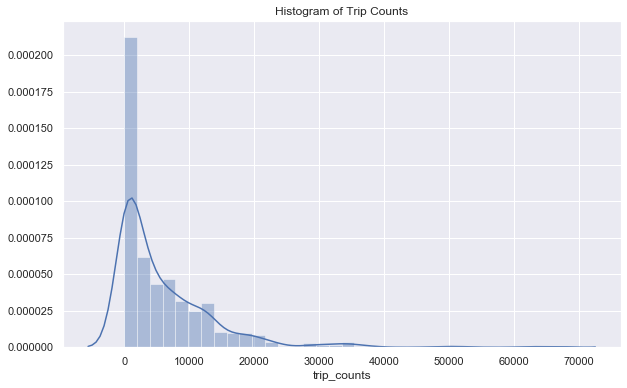

In [430]:
f, ax = plt.subplots(figsize=(10, 6))
sns.set(color_codes=True)
sns.distplot(grid_with['trip_counts'], kde=True);
ax.set_title('Histogram of Trip Counts')

Text(0.5, 1.0, 'Histogram of Log Trip Counts')

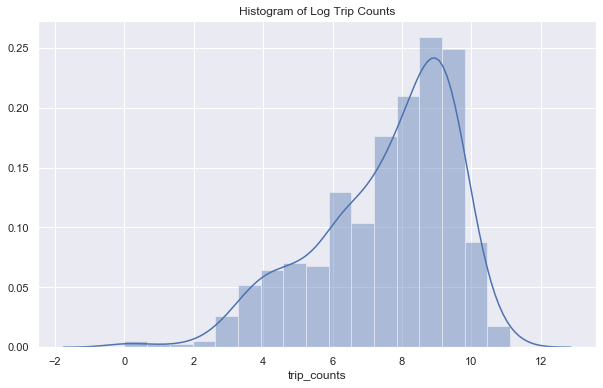

In [450]:
f, ax = plt.subplots(figsize=(10, 6))
sns.set(color_codes=True)
sns.distplot(np.log(grid_with['trip_counts']), kde=True);
ax.set_title('Histogram of Log Trip Counts')

## Model

### Create Final Data Set

In [86]:
# Remove unnecessary columns
final_with = grid_with.drop(columns=['id', 'station_name', 
                                     'status', 'geometry',
                                     'from_station_id', 'name10', 'geoid10',
                                     'log_Dist2TrainStation','log_Dist2PedStreet',
                                     'log_Dist2University','log_medHHInc'])

final_without = grid_without.drop(columns=['id', 'station_name',
                                           'status', 'geometry',
                                     'from_station_id', 'name10', 'geoid10',
                                     'log_Dist2TrainStation','log_Dist2PedStreet',
                                     'log_Dist2University','log_medHHInc'])

final_with = final_with.dropna()

# Split the data 70/30
train_set, test_set = train_test_split(
    final_with,
    test_size=0.3,
    random_state=42,
)

# the target labels
y_train = np.log(train_set["trip_counts"])
y_test = np.log(test_set["trip_counts"])

In [87]:
feature_cols = [
    'neighborhood',
    'total_docks',
    'log_Dist2downtown',
    'log_Dist2BusStop_5',
    'log_Dist2BikeRack_5',
    'log_Dist2Restaurant_5', 
    'log_Dist2Library',
    'log_Dist2AffordableHousing_5', 
    'log_Dist2Park_5',
    'log_Dist2Mural',
    'log_Dist2Landmark', 
    'log_Dist2Intersection_10', 
    'log_laggedTrips_5', 
    'log_Dist2College', 
    'log_Dist2ArtsCenter', 
    'log_Dist2CommunityCenter', 
    'log_Dist2Theatre',
    'log_Dist2Market',
    'percent_public',
    'percent_male',
    'percent_bachelors'
]

num_cols = [
    'total_docks',
    'log_Dist2downtown',
    'log_Dist2BusStop_5',
    'log_Dist2BikeRack_5',
    'log_Dist2Restaurant_5', 
    'log_Dist2Library',
    'log_Dist2AffordableHousing_5', 
    'log_Dist2Park_5',
    'log_Dist2Mural',
    'log_Dist2Landmark', 
    'log_Dist2Intersection_10', 
    'log_laggedTrips_5', 
    'log_Dist2College', 
    'log_Dist2ArtsCenter', 
    'log_Dist2CommunityCenter', 
    'log_Dist2Theatre',
    'log_Dist2Market',
    'percent_public',
    'percent_male',
    'percent_bachelors'
]

cat_cols = [
    'neighborhood'
]

x_train = train_set[feature_cols]
x_test = test_set[feature_cols]

In [88]:
model_name = "randomforestregressor"
param_grid = {
    f"{model_name}__n_estimators": [5, 10, 15, 20, 30, 50, 100, 200],
    f"{model_name}__max_depth": [2, 5, 7, 9, 13, 21, 33, 51, 100],
}

param_grid

{'randomforestregressor__n_estimators': [5, 10, 15, 20, 30, 50, 100, 200],
 'randomforestregressor__max_depth': [2, 5, 7, 9, 13, 21, 33, 51, 100]}

In [89]:
# Set up the column transformer with two transformers
# Scale the numerical columns and one-hot 
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Initialize the pipeline
# NOTE: only use 10 estimators here so it will run in a reasonable time
regr = make_pipeline(
    preprocessor, RandomForestRegressor(n_estimators=20, random_state=42)
)

In [90]:
# Create the grid and use 3-fold CV
grid = GridSearchCV(regr, param_grid, cv=3)

# Run the search
grid.fit(pd.DataFrame(data=x_train.values,columns=feature_cols), y_train);

In [91]:
# Evaluate the best random forest model
best_random = grid.best_estimator_
best_random.score(x_test, y_test)

0.852254506065016

In [94]:
# Calculate the MAPE and MAE of the model, test set
evaluate(best_random,x_test,y_test)

Model Performance
Average Absolute Error: 2720.7246
MAPE = 110.30%.


110.30001355287806

In [95]:
# Calculate the MAPE and MAE of the model, train set
evaluate(best_random,x_train,y_train)

Model Performance
Average Absolute Error: 1716.0099
MAPE = 41.21%.


41.21237289557488

## Prediction vs. Actual: Test Set

In [96]:
# Extract the test data from the original dataset
# This will include the geometry data
X = grid_with.loc[x_test.index]

# Predictions for log of total trip counts
log_predictions = best_random.predict(x_test)

# Convert the predicted test values from log
X['prediction'] = np.exp(log_predictions)

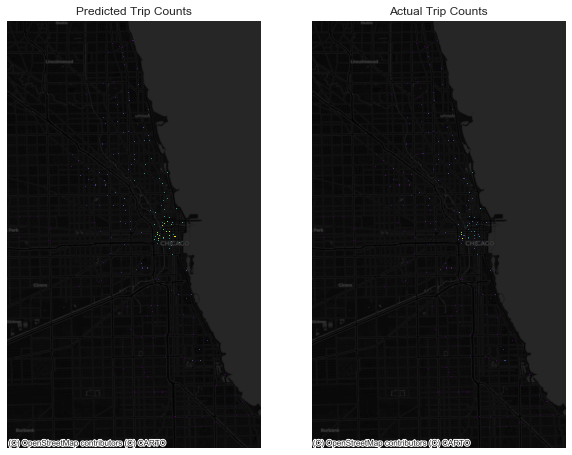

In [97]:
# Plot two columns
fig, axs = plt.subplots(ncols=2, figsize=(10,10))

# Predicted values
X.plot(ax=axs[0], column='prediction',cmap='viridis',edgecolor='none')
ctx.add_basemap(ax=axs[0], crs=X.crs, url=ctx.providers.CartoDB.DarkMatter)
axs[0].set_title("Predicted Trip Counts")

# Actual values
X.plot(ax=axs[1], column='trip_counts',cmap='viridis',edgecolor='none')
ctx.add_basemap(ax=axs[1], crs=X.crs, url=ctx.providers.CartoDB.DarkMatter)
axs[1].set_title("Actual Trip Counts")


axs[0].set_axis_off()
axs[1].set_axis_off()

It's hard to tell the error of prediction for the fishnet model. But we can still get a sense of accuracy by looking at the MAE and MAPE.

## Predict for the cells without a station

In [98]:
x_without = final_without[feature_cols]
x_without = x_without.loc[x_without['neighborhood'].isnull()==False]
x_without['total_docks'] = x_without['total_docks'].fillna(0)
x_without = x_without.loc[x_without['percent_male'].isnull()==False].dropna()
X = grid_without.loc[x_without.index]
# Predictions for log of total trip counts
log_predictions = best_random.predict(x_without)

# Convert the predicted test values from log
X['prediction'] = np.exp(log_predictions)

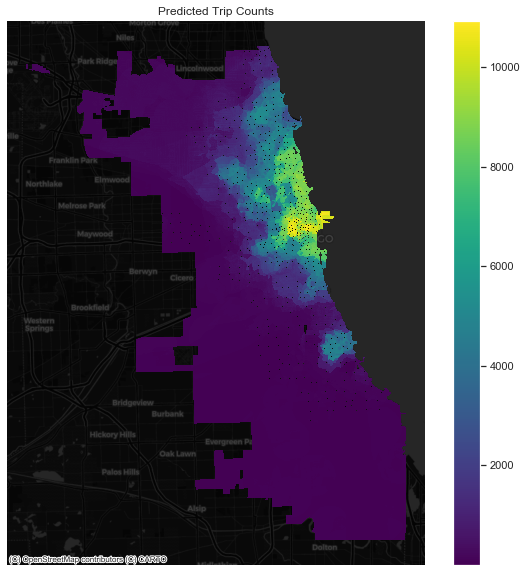

In [100]:
# Plot set up
fig, ax = plt.subplots(figsize=(10,10))

# Predicted values
X.plot(ax=ax, column='prediction',cmap='viridis',edgecolor='none',legend=True)
ctx.add_basemap(ax=ax, crs=X.crs, url=ctx.providers.CartoDB.DarkMatter)
ax.set_title("Predicted Trip Counts")

ax.set_axis_off()
plt.savefig('fishnet.png')